In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

import time
import re

## Создадим класс UrlTree

In [2]:
import numpy as np

from urllib.parse import urlparse
from typing import List


class _UrlNode:
    def __init__(self, path: str, requests_count: int = 0, query: str = None, depth_level: int = None):
        self.path = path
        self.requests_count = requests_count
        self.depth_level = depth_level
        self.query = query
        self.children = []

    def __eq__(self, other):
        return self.path == other.path and self.query == other.query and self.depth_level == other.depth_level

    def __repr__(self):
        return f"<UrlNode; path={self.path}; " \
               f"requests_count={self.requests_count}; " \
               f"query={self.query}; " \
               f"depth_level={self.depth_level}>"

    def append_child(self, new_child):
        for child in self.children:
            if child == new_child:
                # если хотим добавить запрос, но он уже есть, то увеличить счетчик запросов.
                child.requests_count += 1
                return child
        self.children.append(new_child)
        return new_child

    @property
    def entropy(self) -> float:
        """Метод подсчета энтропии Шеннона узла на основании кол-ва запросов к его потомкам.

        Returns:
            float: значение энтропии
        """
        requests_count_sum = sum([node.requests_count for node in self.children])
        if requests_count_sum == 0:
            return 0.0
        probas_vec = [node.requests_count / requests_count_sum for node in self.children]
        return -sum([proba * np.log2(proba) for proba in probas_vec])


class UrlTree:
    """Класс строит дерево урлов для определенного хоста.

    Из данного дерева извлекаются фичи:

        - Энтропия корня, которая отражает дисбаланс дерева у потомков корня (боты парсят только 1 категорию).
        Обозначается как `root_node_entropy`.

        - Максимальная энтропия предпоследнего уровня дерева (боты парсят много товаров, находясь в 1 категории).
        Обозначается как `endpoint_node_entropy`.

    Пример использования:
    ```
        urls = ["https://example.com", "https://example.com/page1", "https://example.com/page2"]
        tree = UrlTree("example.com", urls, max_depth=5)

        print(tree)

        features_dict = tree.calc_features()
        print(features_dict)  # {'root_node_entropy': 1.0, 'endpoint_node_entropy': 1.0}

        for node in tree.bfs():
            print(node)

        for node in tree.dfs():
            print(node)
    ```
    """
    def __init__(self, customer_id: str, urls: list, max_depth: int = None):
        """
        Args:
            customer_id (str): Кастомер, для которого строится дерево.
            urls (list): Список урлов, по которым надо построить дерево.
            max_depth (int, optional): Максимальная глубина дерева. Defaults to None.
        """
        self.customer_id = customer_id
        self.urls = sorted(urls)  # сортируем сырые url'ы, чтобы было по красоте (не обязательно)
        self.splitted_urls = self._parse_urls(self.urls)
        self.root = _UrlNode(customer_id, depth_level=0)
        self.max_depth = max_depth
        self.depth = 0
        self._build_tree()

    def _parse_urls(self, urls: List[str]) -> dict:
        """Метод парсит урлы, разделяя их по символу `/`

        Args:
            urls (str): список сырых урлов

        Returns:
            List[List[str]]: список урлов, разделенных по символу `/`
        """
        parsed_urls: List[dict] = []

        for url in urls:
            parsed_url = urlparse(url.rstrip('/'))
            splitted_path = [path for path in parsed_url.path.lstrip('/').split('/') if path]
            if not splitted_path:
                splitted_path = []  # нужно для корректного подсчета общего числа запросов
                                    # соответствует корню сайта
            parsed_urls.append({'splitted_path': splitted_path, 'query': parsed_url.query})

        return parsed_urls

    def _build_tree(self):
        for url_parsed_dict in self.splitted_urls:
            # url_paths_list - список, состоящий из урла, над которым сделан split('/')
            url_paths_list = url_parsed_dict['splitted_path']
            query = url_parsed_dict['query']

            parent = self.root

            if self.max_depth:
                url_paths_list = url_paths_list[:self.max_depth]

            self.root.requests_count += 1

            for short_path_idx, _ in enumerate(url_paths_list):
                depth_level = short_path_idx + 1

                if depth_level > self.depth:
                    self.depth = depth_level

                child_path = "/" + "/".join(url_paths_list[:short_path_idx + 1])
                requests_count = 1

                child_node = _UrlNode(child_path,
                                     requests_count=requests_count,
                                     query=query,
                                     depth_level=depth_level)

                child_node = parent.append_child(child_node)  # внутри этот метод обновляет счетчик запросов
                parent = child_node  # далее в цикле будем изменять по ссылке

    def __repr__(self):
        return f"<UrlTree customer={self.customer_id}; depth={self.depth}>"

    def bfs(self):
        """Поиск в ширину

        Yields:
            UrlNode: узел дерева
        """
        visited = [self.root]
        queue = [self.root]

        yield self.root

        while queue:
            v = queue.pop(0)
            for w in v.children:
                if w not in visited:
                    visited.append(w)
                    queue.append(w)
                    yield w

    def dfs(self):
        """Поиск в глубину

        Yields:
            UrlNode: узел дерева
        """
        visited = []
        stack = [self.root]

        while stack:
            v = (stack.pop())

            if v in visited:
                continue
            else:
                visited.append(v)
                yield v

            for w in v.children:
                if w not in visited:
                    stack.append(w)

    def calc_endpoints_entropy(self) -> float:
        max_pages_entropy = 0

        for node in self.dfs():
            if node.children and node.depth_level == self.depth - 1:
                # отбираем узлы на предпоследнем уровне, у узлов должны быть потомки
                node_entropy = node.entropy
                if node_entropy > max_pages_entropy:
                    max_pages_entropy = node_entropy

        return max_pages_entropy

    def calc_items_fraud_searching_ratio(self):
        """если у родителя мало запросов и куча запросов к его потомкам, то парсят товары"""
        max_disbalance_ratio = 0

        for node in self.bfs():
            disbalance_ratio = 0

            requests2node = node.requests_count - sum([c.requests_count for c in node.children])

            if node != self.root and len(node.children) > 8 and \
                    all(len(children.children) == 0 for children in node.children):
#                     len(node.children) / requests2node > 5:
                disbalance_ratio = len(node.children) / requests2node if requests2node else len(node.children)

                if disbalance_ratio > max_disbalance_ratio:
                    max_disbalance_ratio = disbalance_ratio

        return max_disbalance_ratio

    def calc_tree_entropy(self):
        sum_entropy = 0.0

        for node in self.dfs():
            if node.children:
                sum_entropy += (self.root.requests_count / node.requests_count) * node.entropy

        return sum_entropy

    def calc_features(self) -> dict:
        return {
            "root_node_entropy": self.root.entropy,
            "endpoint_node_entropy": self.calc_endpoints_entropy(),
            "items_fraud_searching_ratio": self.calc_items_fraud_searching_ratio(),
            "tree_entropy": self.calc_tree_entropy(),
        }


## Подготовимся к считыванию "сырого" датафрейма

In [3]:
common_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-)'
combined_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

In [4]:
def logs_to_df(logfile, output_dir, errors_file):
    with open(logfile) as source_file:
        linenumber = 0
        parsed_lines = []
        for line in tqdm(source_file):
            try:
                log_line = re.findall(combined_regex, line)[0]
                parsed_lines.append(log_line)
            except Exception as e:
                with open(errors_file, 'at') as errfile:
                    print((line, str(e)), file=errfile)
                continue
            linenumber += 1
            if linenumber % 250_000 == 0:
                df = pd.DataFrame(parsed_lines, columns=columns)
                df.to_csv(f'{output_dir}/file_{linenumber}.csv')
                parsed_lines.clear()
        else:
            df = pd.DataFrame(parsed_lines, columns=columns)
            df.to_csv(f'{output_dir}/file_{linenumber}.csv')
            parsed_lines.clear()

In [18]:
%%time

logs_to_df("./data/access.log", "processed_data/", "errors.txt")

0it [00:00, ?it/s]

CPU times: user 1min 14s, sys: 3.65 s, total: 1min 18s
Wall time: 1min 19s


In [34]:
import os

logs_df = None

ctr = 0

for f in tqdm(os.listdir("processed_data")):
    d = pd.read_csv(f"processed_data/{f}", index_col=0)
    if logs_df is None:
        logs_df = d
    else:
        logs_df = pd.concat([logs_df, d], ignore_index=True)
    
    ctr += 1

    if ctr >= 1000:
        break

logs_df.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(10364865, 9)

In [35]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 9 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   client      10364865 non-null  object
 1   userid      10364865 non-null  object
 2   datetime    10364865 non-null  object
 3   method      10364865 non-null  object
 4   request     10364865 non-null  object
 5   status      10364865 non-null  int64 
 6   size        10364865 non-null  int64 
 7   referer     10364845 non-null  object
 8   user_agent  10364858 non-null  object
dtypes: int64(2), object(7)
memory usage: 711.7+ MB


In [36]:
logs_df['client'] = logs_df['client'].astype('category')
del logs_df['userid']
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
logs_df['method'] = logs_df['method'].astype('category')
logs_df['status'] = logs_df['status'].astype('int16')
logs_df['size'] = logs_df['size'].astype('int32')
logs_df['referer'] = logs_df['referer'].astype('category')
logs_df['user_agent'] = logs_df['user_agent'].astype('category')

In [37]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 8 columns):
 #   Column      Non-Null Count     Dtype                                
---  ------      --------------     -----                                
 0   client      10364865 non-null  category                             
 1   datetime    10364865 non-null  datetime64[ns, pytz.FixedOffset(210)]
 2   method      10364865 non-null  category                             
 3   request     10364865 non-null  object                               
 4   status      10364865 non-null  int16                                
 5   size        10364865 non-null  int32                                
 6   referer     10364845 non-null  category                             
 7   user_agent  10364858 non-null  category                             
dtypes: category(4), datetime64[ns, pytz.FixedOffset(210)](1), int16(1), int32(1), object(1)
memory usage: 342.3+ MB


In [38]:
logs_df.to_csv("./logs_df.csv", index=False)

## Считывание преобразованного df

In [5]:
logs_df = pd.read_csv("logs_df.csv")
logs_df['client'] = logs_df['client'].astype('category')
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'])
logs_df['method'] = logs_df['method'].astype('category')
logs_df['status'] = logs_df['status'].astype('int16')
logs_df['size'] = logs_df['size'].astype('int32')
logs_df['referer'] = logs_df['referer'].astype('category')
logs_df['user_agent'] = logs_df['user_agent'].astype('category')

In [6]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 8 columns):
 #   Column      Non-Null Count     Dtype                                
---  ------      --------------     -----                                
 0   client      10364865 non-null  category                             
 1   datetime    10364865 non-null  datetime64[ns, pytz.FixedOffset(210)]
 2   method      10364865 non-null  category                             
 3   request     10364865 non-null  object                               
 4   status      10364865 non-null  int16                                
 5   size        10364865 non-null  int32                                
 6   referer     10364845 non-null  category                             
 7   user_agent  10364858 non-null  category                             
dtypes: category(4), datetime64[ns, pytz.FixedOffset(210)](1), int16(1), int32(1), object(1)
memory usage: 342.3+ MB


In [7]:
logs_df.head()

,client,datetime,method,request,status,size,referer,user_agent
0,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/10481/productModel/100x100,200,2524,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
1,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58920/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58921/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58922/productModel/100x100,200,1301,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/11142/productModel/100x100,200,2397,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


<AxesSubplot:>

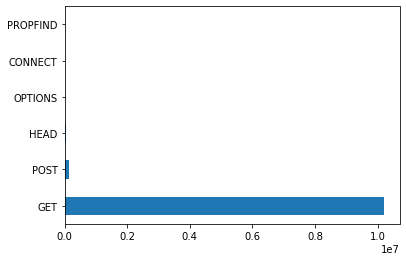

In [8]:
logs_df.method.value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Frequency'>

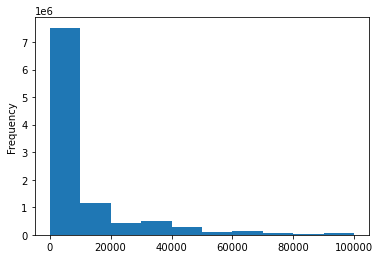

In [9]:
logs_df[logs_df['size'] < 100000]['size'].plot(kind='hist')

In [177]:
logs_df.head()

,client,datetime,method,request,status,size,referer,user_agent
0,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/10481/productModel/100x100,200,2524,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
1,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58920/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58921/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58922/productModel/100x100,200,1301,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/11142/productModel/100x100,200,2397,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


### Возьмем лишь 500 000 первых записей.

Можно и больше, отличие лишь по времени выполнения. 500 000 записей скорятся за 17 минут на MacBook Pro M1.

Группируем датафрейм по дням и по часам - наш алгоритм отрабатывает раз в час.

Внутри часа сгруппируем по User-agent — тк было замечено, что агенты меняются редко.

In [17]:
cutted_df = logs_df.head(500_000)

times = pd.DatetimeIndex(cutted_df['datetime'])
grouped_by_time = cutted_df.groupby([times.day, times.hour])

In [20]:
logs_df.head()

,client,datetime,method,request,status,size,referer,user_agent
0,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/10481/productModel/100x100,200,2524,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
1,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58920/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58921/productModel/100x100,200,1245,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,46.100.194.189,2019-01-23 08:46:01+03:30,GET,/image/58922/productModel/100x100,200,1301,"https://www.zanbil.ir/filter?f=p12786,b485,ste...",Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
4,217.66.203.161,2019-01-23 08:46:01+03:30,GET,/image/11142/productModel/100x100,200,2397,"https://www.zanbil.ir/filter/p44,b141,stexists",Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


In [21]:
def make_ratio_features(grouped):    
    N = 5  # топ URL по кол-ву запросов к ним в рамках UA
    counter = []
    # маппинг UA -> временная группа -> список ip, засвеченных на ней
    ua__timegroup__ip_mapping = dict()

    for groupname, df_hour in tqdm(grouped, total=len(grouped)):

        df_hour['ip_req_counts'] = df_hour.groupby('client')['request'].transform('count')
        df_hour['ip_counts'] = df_hour.groupby('user_agent')['client'].transform('count')

        hour_groups = df_hour.groupby(['user_agent'])

        for ua, df_ua in tqdm(hour_groups, total=len(hour_groups), leave=False):
            if df_ua.empty or not ua or ua == '-':
                continue

            df_ua = df_ua.copy()

            # Смотрим топовый ip по кол-ву запросов с него в рамках этого UA.
            top_ip_reqs_row = df_ua.sort_values('ip_req_counts', ascending=False).iloc[0]
            top_ip = top_ip_reqs_row.client
            top_reqs_cout = top_ip_reqs_row.ip_req_counts

            # TODO: get post requests, get_requests features here
            methods_counter = df_hour[df_hour.client == top_ip].method.value_counts()

            post_requests = methods_counter.get("POST", 0)
            get_requests = methods_counter.get("GET", 0)

            post_div_get = post_requests / get_requests if get_requests != 0 else post_requests

            # строим дерево урлов и считаем его дисбалансированность
            urls = df_ua.request.tolist()
            tree = UrlTree('host.com', urls, max_depth=4)
            features_dict = tree.calc_features()

            root_node_entropy = features_dict['root_node_entropy']
            endpoint_node_entropy = features_dict['endpoint_node_entropy']
            items_fraud_searching_ratio = features_dict['items_fraud_searching_ratio']
            tree_entropy = features_dict['tree_entropy']
            
            # Наполняем маппинг ua -> timegroup -> ip_list
            ua_group = ua__timegroup__ip_mapping.get(ua, {})
            ua_group_time = ua_group.get(groupname, [])
            ua_group_time += df_ua.request.tolist()
            
            ua__timegroup__ip_mapping[ua] = ua_group
            ua_group[groupname] = ua_group_time

            counter.append({
                'ua': ua,
                'requests': len(df_ua),
                'group': groupname,
                'top_ip': top_ip,
                'top_reqs_cout': top_reqs_cout,
                'root_node_entropy': root_node_entropy,
                'endpoint_node_entropy': endpoint_node_entropy,
                'items_fraud_searching_ratio': items_fraud_searching_ratio,
                'tree_entropy': tree_entropy,
                'post_requests': post_requests,
                'get_requests': get_requests,
                'post_div_get': post_div_get,
            })
    return pd.DataFrame(counter), ua__timegroup__ip_mapping

In [22]:
res = make_ratio_features(grouped_by_time)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

  0%|          | 0/28338 [00:00<?, ?it/s]

In [23]:
counter, mapping = res

In [24]:
counter.to_csv("./counter500k.csv", index=False)

In [3]:
counter = pd.read_csv("./counter500k.csv")

In [4]:
counter.head()

,ua,requests,group,top_ip,top_reqs_cout,root_node_entropy,endpoint_node_entropy,items_fraud_searching_ratio,tree_entropy,post_requests,get_requests,post_div_get
0,Dalvik/1.6.0 (Linux; U; Android 4.2.1; HUAWEI ...,4,"(23, 8)",5.114.145.132,4,2.000000,0.0,0,2.000000,0,4,0.0
1,Dalvik/1.6.0 (Linux; U; Android 4.2.2; GT-I919...,6,"(23, 8)",5.120.57.13,6,2.251629,0.0,0,2.251629,0,6,0.0
2,Dalvik/1.6.0 (Linux; U; Android 4.2.2; H30-U10...,1,"(23, 8)",5.215.120.67,1,-0.000000,0.0,0,0.000000,0,1,0.0
3,Dalvik/1.6.0 (Linux; U; Android 4.2.2; HUAWEI ...,1,"(23, 8)",5.239.226.11,1,-0.000000,0.0,0,0.000000,0,1,0.0
4,Dalvik/1.6.0 (Linux; U; Android 4.2.2; ME173X ...,1,"(23, 8)",151.238.203.108,1,-0.000000,0.0,0,0.000000,0,1,0.0


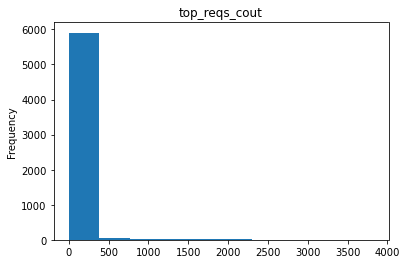

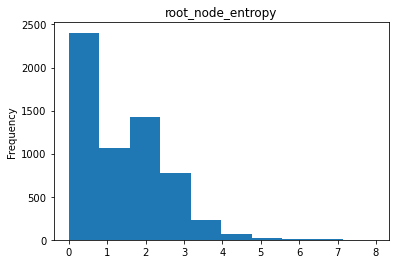

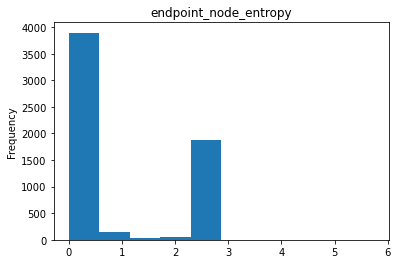

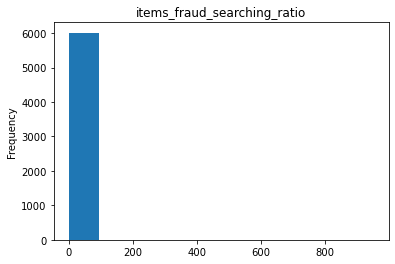

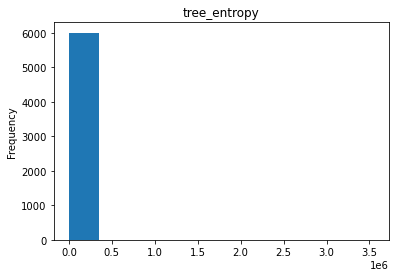

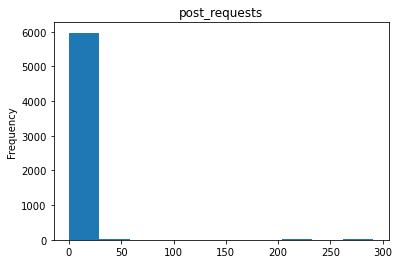

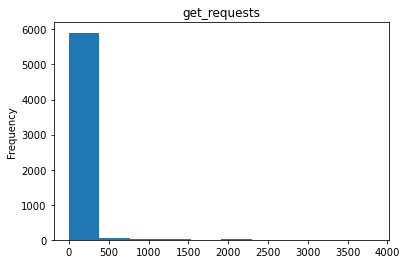

In [5]:
tmp_df = counter[['top_reqs_cout', 'root_node_entropy',
                  'endpoint_node_entropy', 'items_fraud_searching_ratio',
                  'tree_entropy', 'post_requests', 'get_requests']]

for column in tmp_df.columns:
    tmp_df[column].plot(kind='hist')
    plt.title(column)
    plt.show()

In [6]:
tmp_df.shape

(6026, 7)

In [7]:
sns.pairplot(tmp_df.sample(500))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1397f00d0> (for post_execute):


KeyboardInterrupt: 

In [8]:
def get_anomalies_by_iqr(data, tolerance=2):
    data = data.apply(lambda x: np.log2(x) if x else None)
    data = data.dropna()
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lboundary = q1 - tolerance * iqr
    rboundary = q3 + tolerance * iqr
    return data[(data < lboundary) | (data > rboundary)]

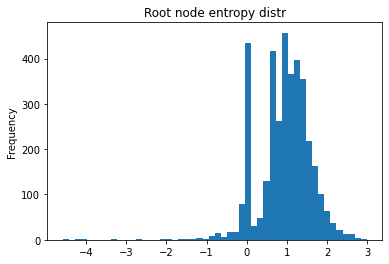

In [10]:
counter.root_node_entropy.apply(lambda x: np.log2(x) if x else None).plot(kind='hist',
                                                                          bins=50,
                                                                          title="Root node entropy distr")

root_node_entropy_anomalies = get_anomalies_by_iqr(counter.root_node_entropy).index

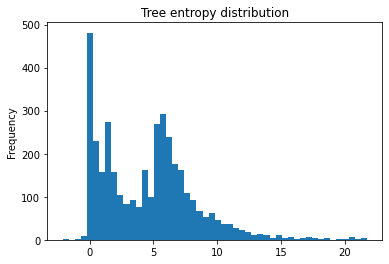

In [12]:
d = counter.tree_entropy.apply(lambda x: np.log2(x) if x else None).dropna()
d.plot(kind='hist', bins=50, title="Tree entropy distribution")  # bimodal

rboundary = np.percentile(d, 99)

tree_entropy_anomalies = d[d > rboundary].index

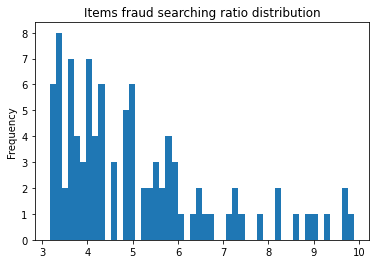

In [13]:
counter.items_fraud_searching_ratio.apply(lambda x: np.log2(x) if x else None).plot(kind='hist',
                                                                                    bins=50,
                                                                                    title="Items fraud searching ratio distribution")

rboundary = np.percentile(counter.items_fraud_searching_ratio.apply(lambda x: np.log2(x) if x else 0), 99.9)

items_fraud_searching_ratio_anomalies = counter[counter.items_fraud_searching_ratio > rboundary].index

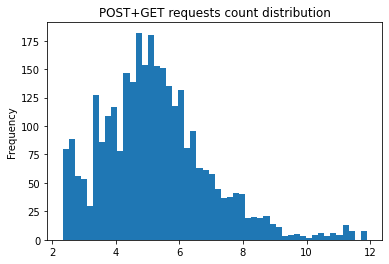

In [14]:
d = (counter.post_requests + counter.get_requests).apply(lambda x: np.log2(x) if x else None)
d = d[(d > 2)]

d.plot(kind='hist', bins=50, title="POST+GET requests count distribution")

rboundary = np.percentile(d, 99)

requests_anomalies = d[d > rboundary].index

In [17]:
from functools import reduce

anomalies = [
    set(root_node_entropy_anomalies),
    set(tree_entropy_anomalies),
    set(items_fraud_searching_ratio_anomalies),
    set(requests_anomalies),
]

anomalies_union = reduce(lambda x, y: x | y, anomalies)

len(anomalies_union)

146

In [18]:
len(anomalies_union) / len(counter)

0.024228343843345504

In [20]:
counter[counter.index.isin(anomalies_union)].ua.str.lower().str.contains("bot").value_counts()

False    106
True      40
Name: ua, dtype: int64

In [254]:
len(counter[counter.index.isin(anomalies_union)].ua)

146

In [26]:
counter[counter.index.isin(anomalies_union) & ~counter.ua.str.contains("bot")].sort_values('top_ip').iloc[50:100]

,ua,requests,group,top_ip,top_reqs_cout,root_node_entropy,endpoint_node_entropy,items_fraud_searching_ratio,tree_entropy,post_requests,get_requests,post_div_get
1889,Mozilla/5.0 (Linux; Android 4.4.2; H30-U10 Bui...,11,"(23, 10)",5.120.206.105,11,0.439497,2.321928,0,1.277495e+01,0,11,0.000000
1593,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like...,1059,"(23, 9)",5.121.153.3,144,2.631829,2.320380,10,1.204239e+04,0,144,0.000000
4045,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,25,"(23, 14)",5.123.236.135,21,0.482179,0.000000,0,4.821792e-01,0,21,0.000000
5832,Mozilla/5.0 (Linux; U; Android 7.1.1; en-US; S...,13,"(23, 15)",5.127.250.173,14,0.391244,0.000000,0,4.274953e+00,0,14,0.000000
2437,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,78,"(23, 10)",5.160.157.20,78,5.323112,4.058814,17,2.291131e+01,0,78,0.000000
5871,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,46,"(23, 15)",5.160.157.20,46,4.132258,4.000000,16,1.563226e+01,0,46,0.000000
1411,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,122,"(23, 9)",5.160.157.20,122,5.589917,4.760648,28,2.432537e+01,0,122,0.000000
4772,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,123,"(23, 14)",5.160.157.20,123,6.015344,4.262692,20,2.881148e+01,0,123,0.000000
5269,Mozilla/5.0 (Linux; Android 4.4.2; CHM-U01 Bui...,7,"(23, 15)",5.200.119.15,7,0.591673,2.321928,0,4.600732e+00,0,7,0.000000
2266,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,23,"(23, 10)",5.208.216.207,23,0.258019,0.000000,0,4.920152e+00,0,23,0.000000


In [222]:
from sklearn.decomposition import PCA

vec_df = counter[['root_node_entropy', 'endpoint_node_entropy', 'items_fraud_searching_ratio', 'tree_entropy']].copy()
vec_df['requests'] = counter['get_requests'] + counter['post_requests']

<AxesSubplot:>

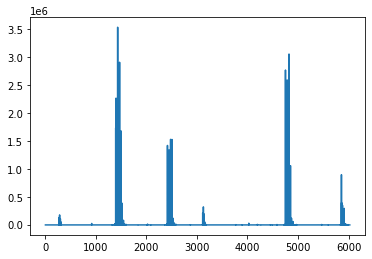

In [223]:
pca = PCA(n_components=1)

res = pca.fit_transform(vec_df)

pca.explained_variance_ratio_.sum()

pd.Series(res.ravel()).plot()

In [ ]:
16 + 